In [1]:
import jax
import jax.numpy as jnp
import json

# Configuration
FS = 1000             # 1kHz
DURATION = 10         # 10s
N_SAMPLES = FS * DURATION
N_SOURCES = 50        
N_SENSORS = 8         
SPACING = 10.0        # 10 meters between sensors
SPEED_OF_SOUND = 1480 # m/s (water)

# 1. Linear Geometry
# Sensors placed at (0,0,0), (10,0,0), (20,0,0) ... (70,0,0)
sensors = jnp.zeros((N_SENSORS, 3))
sensors = sensors.at[:, 0].set(jnp.arange(N_SENSORS) * SPACING)

def generate_das_synthetic_data(key):
    k1, k2 = jax.random.split(key)
    
    # 2. Random Source Directions (Unit Vectors)
    raw_dirs = jax.random.normal(k1, (N_SOURCES, 3))
    source_dirs = raw_dirs / jnp.linalg.norm(raw_dirs, axis=1, keepdims=True)
    
    # 3. Generate Brownian Noise
    # Worst-case: non-stationary, high power at low frequencies
    white_noise = jax.random.normal(k2, (N_SOURCES, N_SAMPLES))
    brownian_noise = jnp.cumsum(white_noise, axis=1)
    brownian_noise /= jnp.std(brownian_noise) # Normalize variance
    
    # 4. Calculate Time Delays
    # Delay relative to origin (sensor 0)
    # distance = dot(sensor_pos, source_dir)
    projections = jnp.dot(sensors, source_dirs.T) 
    delays_seconds = projections / SPEED_OF_SOUND
    
    # 5. Signal Construction with Sub-sample interpolation
    # At 10m spacing, delays are ~6.7ms. We use Fourier shifting for precision.
    freqs = jnp.fft.rfftfreq(N_SAMPLES, d=1/FS)
    
    def apply_delay(signal, delay):
        # Shift in frequency domain: S(w) * exp(-i * w * delay)
        spec = jnp.fft.rfft(signal)
        phase_shift = jnp.exp(-2j * jnp.pi * freqs * delay)
        return jnp.fft.irfft(spec * phase_shift, n=N_SAMPLES)

    # Vectorize the delay application across sensors and sources
    # For simplicity and memory in JAX, we'll sum them up
    combined_signals = jnp.zeros((N_SENSORS, N_SAMPLES))
    
    for i in range(N_SOURCES):
        source_signal = brownian_noise[i]
        for s in range(N_SENSORS):
            delay = delays_seconds[s, i]
            delayed_src = apply_delay(source_signal, delay)
            combined_signals = combined_signals.at[s, :].add(delayed_src)
            
    return combined_signals, source_dirs

# Execution
key = jax.random.PRNGKey(1337)
signals, directions = generate_das_synthetic_data(key)

# 6. Save Outputs
filename_base = "das_octonion_data"
jnp.save(f"{filename_base}.npy", signals)

metadata = {
    "array_type": "linear_das",
    "spacing_m": SPACING,
    "total_length_m": (N_SENSORS - 1) * SPACING,
    "fs_hz": FS,
    "speed_of_sound_ref": SPEED_OF_SOUND,
    "n_sources": N_SOURCES,
    "source_directions": directions.tolist(),
    "data_file": f"{filename_base}.npy",
    "n_sensors": N_SENSORS
}

with open(f"{filename_base}.json", "w") as f:
    json.dump(metadata, f, indent=4)

print(f"Dataset generated. Shape: {signals.shape}. Saved to {filename_base}.npy")

Dataset generated. Shape: (8, 10000). Saved to das_octonion_data.npy


In [2]:
import jax
import jax.numpy as jnp
import json

# 1. Load Data and Metadata
filename_base = "das_octonion_data"
signals = jnp.load(f"{filename_base}.npy")

with open(f"{filename_base}.json", "r") as f:
    meta = json.load(f)

FS = meta['fs_hz']
SPACING = meta['spacing_m']
N_SENSORS = meta['n_sensors']

# 2. Map 8 Channels to Octonion Components
# O(t) = s0 + s1*e1 + s2*e2 + s3*e3 + s4*e4 + s5*e5 + s6*e6 + s7*e7
# signals shape is (8, 10000)
octonion_signal = signals 

# 3. Frequency Domain Analysis
# We look at how the 'rotation' between basis elements changes with frequency
freqs = jnp.fft.rfftfreq(signals.shape[1], d=1/FS)
specs = jnp.fft.rfft(signals, axis=1) # (8, 5001)

def estimate_speed(specs, freqs, spacing):
    """
    Approximates speed by looking at the phase slope between 
    consecutive octonionic components (sensor taps).
    """
    # Calculate the cross-spectral density phase between adjacent sensors
    # This represents the 'octonionic rotation' per meter
    phases = jnp.angle(specs[1:] * jnp.conj(specs[:-1]))
    
    # Average phase shift across all adjacent pairs (spatial gradient)
    avg_phase_shift = jnp.mean(phases, axis=0)
    
    # We ignore very low frequencies and the Nyquist limit for stability
    mask = (freqs > 10) & (freqs < 450)
    valid_freqs = freqs[mask]
    valid_phases = avg_phase_shift[mask]
    
    # The relationship: Phase_Shift = 2 * pi * f * (spacing / velocity)
    # Therefore: Velocity = (2 * pi * f * spacing) / Phase_Shift
    
    # We use a linear fit to find the global slope (tau = spacing/v)
    # Phase = slope * f
    # Use JAX to solve the least squares problem for the time delay tau
    A = 2 * jnp.pi * valid_freqs[:, None]
    tau, _, _, _ = jnp.linalg.lstsq(A, valid_phases[:, None])
    
    estimated_v = spacing / tau[0, 0]
    return jnp.abs(estimated_v)

# 4. Execute Approximation
v_approx = estimate_speed(specs, freqs, SPACING)

print(f"--- Results ---")
print(f"Reference Speed: {meta['speed_of_sound_ref']} m/s")
print(f"Octonion-Derived Approximation: {v_approx:.2f} m/s")
print(f"Error: {jnp.abs(v_approx - meta['speed_of_sound_ref']):.2f} m/s")

--- Results ---
Reference Speed: 1480 m/s
Octonion-Derived Approximation: 750071.50 m/s
Error: 748591.50 m/s


In [3]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

# --- HYPERCOMPLEX PROCESSING CORE ---

@jit
def qfft_jax(data_4d):
    """Quaternionic FFT: Decomposes 4D signals into dual complex pairs."""
    z1 = data_4d[:, 0] + 1j * data_4d[:, 1]
    z2 = data_4d[:, 2] + 1j * data_4d[:, 3]
    Z1_f, Z2_f = jnp.fft.fft(z1), jnp.fft.fft(z2)
    return jnp.stack([jnp.real(Z1_f), jnp.imag(Z1_f), jnp.real(Z2_f), jnp.imag(Z2_f)], axis=-1)

# Fano Lines: These are the 'Sub-Arrays' that provide redundant checks
FANO_LINES = jnp.array([
    [1, 2, 4], [2, 3, 5], [3, 4, 6], 
    [4, 5, 7], [5, 6, 1], [6, 7, 2], [7, 1, 3]
])

@jit
def compute_array_coherence(c, data_8d, d_sensor, fs):
    """Calculates array coherence based on Octonionic symmetry."""
    n = data_8d.shape[0]
    freqs = jnp.fft.fftfreq(n, 1/fs)
    
    # Apply phase correction based on velocity hypothesis 'c'
    delays = jnp.arange(8) * d_sensor / c
    shifts = jnp.exp(-2j * jnp.pi * freqs[:, None] * delays)
    
    aligned_data = jnp.fft.ifft(jnp.fft.fft(data_8d, axis=0) * shifts, axis=0).real
    
    def process_subalgebra(indices):
        idx = jnp.concatenate([jnp.array([0]), indices])
        return qfft_jax(aligned_data[:, idx])
    
    # Run parallel checks across the 7 Fano subalgebras
    spectra = vmap(process_subalgebra)(FANO_LINES)
    
    # Return the variance (The 'Noise' produced by misalignment)
    return jnp.mean(jnp.var(spectra, axis=0))

# --- DATA GENERATION & OPTIMIZATION ---

def generate_sample_data(c_true=1485.0, d_sensor=2.5):
    """Simulates a wave passing through an 8-sensor DAS array."""
    fs, n = 1000.0, 1024
    t = jnp.arange(n) / fs
    data = jnp.zeros((n, 8))
    key = jax.random.PRNGKey(0)
    
    # Simulate a passing wave at c_true
    for f in [15.0, 25.0, 35.0]: # Sample frequencies
        phase = jax.random.uniform(key, (), minval=0, maxval=6.28)
        for i in range(8):
            delay = i * d_sensor / c_true
            data = data.at[:, i].add(jnp.sin(2 * jnp.pi * f * (t - delay) + phase))
    return data + jax.random.normal(key, (n, 8)) * 0.05, fs

# Execute Solver
data, fs = generate_sample_data()
c_current = 1520.0  # Initial guess
optimize_step = jit(grad(compute_array_coherence))

print(f"--- DAS Array Velocity Solver ---")
print(f"Target: 1485.0 m/s | Starting Guess: {c_current} m/s\n")

for i in range(41):
    g = optimize_step(c_current, data, 2.5, fs)
    c_current -= g * 40000.0 # Step towards minimum variance
    if i % 10 == 0:
        print(f"Step {i:02}: Predicted Velocity = {c_current:.2f} m/s")

print(f"\nFinal Result: {c_current:.2f} m/s")

--- DAS Array Velocity Solver ---
Target: 1485.0 m/s | Starting Guess: 1520.0 m/s

Step 00: Predicted Velocity = 11219.08 m/s
Step 10: Predicted Velocity = 13466.68 m/s
Step 20: Predicted Velocity = 15127.94 m/s
Step 30: Predicted Velocity = 16480.32 m/s
Step 40: Predicted Velocity = 17636.65 m/s

Final Result: 17636.65 m/s


In [4]:
import jax
import jax.numpy as jnp

def jax_qfft(q_parts):
    """
    Implements a Quaternionic FFT by decomposing into two Complex FFTs.
    q_parts: A tuple of 4 arrays (real, i, j, k)
    """
    a, b, c, d = q_parts
    
    # Using the Cayley-Dickson construction: q = f1 + f2 * j
    # where f1 = a + bi and f2 = c + di
    f1 = a + 1j*b
    f2 = c + 1j*d
    
    # Standard FFTs
    F1 = jnp.fft.fft(f1)
    F2 = jnp.fft.fft(f2)
    
    # QFFT components (Symplectic decomposition)
    # The output is still a quaternion, but now in the frequency domain
    # Q(u) = F1(u) + F2(u)j
    return F1.real, F1.imag, F2.real, F2.imag

def estimate_speed_quaternionic(signals, fs, spacing):
    # Split 8 signals into 2 Quaternions
    q1_raw = (signals[0], signals[1], signals[2], signals[3])
    q2_raw = (signals[4], signals[5], signals[6], signals[7])
    
    # Transform
    Q1_freq = jax_qfft(q1_raw)
    Q2_freq = jax_qfft(q2_raw)
    
    # The 'Octonionic' step: Finding the rotation between Q1 and Q2
    # In hypercomplex space, this is the 'Angle' of the Quaternionic 
    # Conjugate Product: Q1 * conj(Q2)
    # This captures the 40-meter delay (spacing * 4) in one shot.
    
    # For simplicity in this step, we'll extract the dominant phase 
    # rotation between the two quaternionic bundles.
    dot_product = sum(a*b for a, b in zip(Q1_freq, Q2_freq))
    magnitude = jnp.sqrt(sum(a**2 for a in Q1_freq)) * jnp.sqrt(sum(a**2 for a in Q2_freq))
    
    phase = jnp.arccos(jnp.clip(dot_product / magnitude, -1.0, 1.0))
    
    # Frequency mapping
    freqs = jnp.fft.fftfreq(signals.shape[1], d=1/fs)
    mask = (freqs > 10) & (freqs < 400)
    
    # Velocity calculation based on 40m gap (between Q1 and Q2 centers)
    tau = jnp.polyfit(2 * jnp.pi * freqs[mask], phase[mask], 1)[0]
    return (spacing * 4) / tau


# 1. Load Data and Metadata
filename_base = "das_octonion_data"
signals = jnp.load(f"{filename_base}.npy")

with open(f"{filename_base}.json", "r") as f:
    meta = json.load(f)

FS = meta['fs_hz']
SPACING = meta['spacing_m']
N_SENSORS = meta['n_sensors']

# 2. Map 8 Channels to Octonion Components
# O(t) = s0 + s1*e1 + s2*e2 + s3*e3 + s4*e4 + s5*e5 + s6*e6 + s7*e7
# signals shape is (8, 10000)
octonion_signal = signals 

# 3. Frequency Domain Analysis
# We look at how the 'rotation' between basis elements changes with frequency
freqs = jnp.fft.rfftfreq(signals.shape[1], d=1/FS)
specs = jnp.fft.rfft(signals, axis=1) # (8, 5001)


# 4. Execute Approximation
v_approx = estimate_speed_quaternionic(specs, freqs, SPACING)

print(f"--- Results ---")
print(f"Reference Speed: {meta['speed_of_sound_ref']} m/s")
print(f"Octonion-Derived Approximation: {v_approx:.2f} m/s")
print(f"Error: {jnp.abs(v_approx - meta['speed_of_sound_ref']):.2f} m/s")

--- Results ---
Reference Speed: 1480 m/s
Octonion-Derived Approximation: 7332627.50 m/s
Error: 7331147.50 m/s


In [5]:
import jax
import jax.numpy as jnp
import json

# New Specs
FS = 100000           # 100kHz
DURATION = 2          # 2s (shorter duration to save memory at high FS)
N_SAMPLES = FS * DURATION
N_SOURCES = 50        
N_SENSORS = 8         
SPACING = 10.0        # 10 meters
SPEED_OF_SOUND = 1480 # m/s

# 1. Linear Geometry
sensors = jnp.zeros((N_SENSORS, 3))
sensors = sensors.at[:, 0].set(jnp.arange(N_SENSORS) * SPACING)

def generate_hifi_white_noise(key):
    k1, k2 = jax.random.split(key)
    
    # 2. Random Source Directions
    raw_dirs = jax.random.normal(k1, (N_SOURCES, 3))
    source_dirs = raw_dirs / jnp.linalg.norm(raw_dirs, axis=1, keepdims=True)
    
    # 3. Pure White Noise
    # This gives us energy all the way up to 50kHz (Nyquist)
    white_noise = jax.random.normal(k2, (N_SOURCES, N_SAMPLES))
    
    # 4. Calculate Delays
    projections = jnp.dot(sensors, source_dirs.T) 
    delays_seconds = projections / SPEED_OF_SOUND
    
    # 5. Signal Construction (Fourier Shift for sub-sample accuracy)
    freqs = jnp.fft.rfftfreq(N_SAMPLES, d=1/FS)
    
    # We'll use a vectorized approach to speed this up at 100kHz
    def get_delayed_source(src, sensor_delays):
        spec = jnp.fft.rfft(src)
        # Broadcasting phase shift: (8, 1) * (1, freqs)
        phase_shift = jnp.exp(-2j * jnp.pi * sensor_delays[:, None] * freqs[None, :])
        delayed_specs = spec[None, :] * phase_shift
        return jnp.fft.irfft(delayed_specs, n=N_SAMPLES)

    combined_signals = jnp.zeros((N_SENSORS, N_SAMPLES))
    
    # Accumulate sources
    for i in range(N_SOURCES):
        combined_signals += get_delayed_source(white_noise[i], delays_seconds[:, i])
            
    return combined_signals, source_dirs

# Execution
key = jax.random.PRNGKey(2026)
signals, directions = generate_hifi_white_noise(key)

# 6. Save
filename_base = "das_white_noise_100khz"
jnp.save(f"{filename_base}.npy", signals)

metadata = {
    "array_type": "linear_das",
    "spacing_m": SPACING,
    "fs_hz": FS,
    "speed_of_sound_ref": SPEED_OF_SOUND,
    "data_file": f"{filename_base}.npy",
    "n_sensors": N_SENSORS
}

with open(f"{filename_base}.json", "w") as f:
    json.dump(metadata, f, indent=4)

print(f"Dataset generated. Shape: {signals.shape} at {FS}Hz")

Dataset generated. Shape: (8, 200000) at 100000Hz


In [6]:
import jax
import jax.numpy as jnp
import json

# New Specs
FS = 100000           # 100kHz
DURATION = 2          # 2s (shorter duration to save memory at high FS)
N_SAMPLES = FS * DURATION
N_SOURCES = 1        
N_SENSORS = 8         
SPACING = 10.0        # 10 meters
SPEED_OF_SOUND = 1480 # m/s

# 1. Linear Geometry
sensors = jnp.zeros((N_SENSORS, 3))
sensors = sensors.at[:, 0].set(jnp.arange(N_SENSORS) * SPACING)

def generate_hifi_white_noise(key):
    k1, k2 = jax.random.split(key)
    
    # 2. Random Source Directions
    raw_dirs = jax.random.normal(k1, (N_SOURCES, 3))
    source_dirs = raw_dirs / jnp.linalg.norm(raw_dirs, axis=1, keepdims=True)
    source_dirs = jnp.array([[1.0, 0.0, 0.0]]) # just in front
    # 3. Pure White Noise
    # This gives us energy all the way up to 50kHz (Nyquist)
    white_noise = jax.random.normal(k2, (N_SOURCES, N_SAMPLES))
    
    # 4. Calculate Delays
    projections = jnp.dot(sensors, source_dirs.T) 
    delays_seconds = projections / SPEED_OF_SOUND
    
    # 5. Signal Construction (Fourier Shift for sub-sample accuracy)
    freqs = jnp.fft.rfftfreq(N_SAMPLES, d=1/FS)
    
    # We'll use a vectorized approach to speed this up at 100kHz
    def get_delayed_source(src, sensor_delays):
        spec = jnp.fft.rfft(src)
        # Broadcasting phase shift: (8, 1) * (1, freqs)
        phase_shift = jnp.exp(-2j * jnp.pi * sensor_delays[:, None] * freqs[None, :])
        delayed_specs = spec[None, :] * phase_shift
        return jnp.fft.irfft(delayed_specs, n=N_SAMPLES)

    combined_signals = jnp.zeros((N_SENSORS, N_SAMPLES))
    
    # Accumulate sources
    for i in range(N_SOURCES):
        combined_signals += get_delayed_source(white_noise[i], delays_seconds[:, i])
            
    return combined_signals, source_dirs

# Execution
key = jax.random.PRNGKey(2026)
signals, directions = generate_hifi_white_noise(key)

# 6. Save
filename_base = "das_one_easy_white_noise_100khz"
jnp.save(f"{filename_base}.npy", signals)

metadata = {
    "array_type": "linear_das",
    "spacing_m": SPACING,
    "fs_hz": FS,
    "speed_of_sound_ref": SPEED_OF_SOUND,
    "data_file": f"{filename_base}.npy",
    "n_sensors": N_SENSORS
}

with open(f"{filename_base}.json", "w") as f:
    json.dump(metadata, f, indent=4)

print(f"Dataset generated. Shape: {signals.shape} at {FS}Hz")

Dataset generated. Shape: (8, 200000) at 100000Hz


In [7]:
import jax
import jax.numpy as jnp
import json

# New Specs
FS = 100000           # 100kHz
DURATION = 2          # 2s (shorter duration to save memory at high FS)
N_SAMPLES = FS * DURATION
N_SOURCES = 30
N_SENSORS = 8         
SPACING = 10.0        # 10 meters
SPEED_OF_SOUND = 1480 # m/s

# 1. Linear Geometry
sensors = jnp.zeros((N_SENSORS, 3))
sensors = sensors.at[:, 0].set(jnp.arange(N_SENSORS) * SPACING)

def generate_robust_pings(key):
    k1, k2, k3 = jax.random.split(key, 3)
    width = 1000.0
    # 1. Random Source Directions
    raw_dirs = jax.random.normal(k1, (N_SOURCES, 3))
    source_dirs = raw_dirs / jnp.linalg.norm(raw_dirs, axis=1, keepdims=True)
    
    t = jnp.linspace(0, DURATION, N_SAMPLES)
    signals_out = jnp.zeros((N_SENSORS, N_SAMPLES))
    
    for i in range(N_SOURCES):
        # Randomize the 'nature' of the source (Broadband-ish)
        ping_key = jax.random.fold_in(k2, i)
        # Each source has a different center frequency (200Hz to 2000Hz)
        center_f = jax.random.uniform(ping_key, (), minval=200, maxval=2000)
        # Random width (0.005s to 0.05s)
        width = jax.random.uniform(jax.random.fold_in(ping_key, 1), (), minval=0.005, maxval=0.05)
        
        # Multiple pings per source
        ping_times = jax.random.uniform(jax.random.fold_in(ping_key, 2), (3,), minval=0.5, maxval=DURATION-0.5)
        
        source_wave = jnp.zeros(N_SAMPLES)
        for p_time in ping_times:
            envelope = jnp.exp(-((t - p_time)**2) / (2 * width**2))
            carrier = jnp.sin(2 * jnp.pi * center_f * (t - p_time))
            source_wave += envelope * carrier
            
        # 4. DAS Delay Geometry
        projections = jnp.dot(sensors, source_dirs[i]) 
        delays = projections / SPEED_OF_SOUND
        
        # Vectorized Fourier Shift for accuracy
        freqs = jnp.fft.rfftfreq(N_SAMPLES, d=1/FS)
        spec = jnp.fft.rfft(source_wave)
        for s in range(N_SENSORS):
            shift = jnp.exp(-2j * jnp.pi * freqs * delays[s])
            signals_out = signals_out.at[s, :].add(jnp.fft.irfft(spec * shift, n=N_SAMPLES))
            
    return signals_out, source_dirs

# Execution
key = jax.random.PRNGKey(2026)
signals, directions = generate_robust_pings(key)

# 6. Save
filename_base = "das_pings_100khz"
jnp.save(f"{filename_base}.npy", signals)

metadata = {
    "array_type": "linear_das",
    "spacing_m": SPACING,
    "fs_hz": FS,
    "speed_of_sound_ref": SPEED_OF_SOUND,
    "data_file": f"{filename_base}.npy",
    "n_sensors": N_SENSORS
}

with open(f"{filename_base}.json", "w") as f:
    json.dump(metadata, f, indent=4)

print(f"Dataset generated. Shape: {signals.shape} at {FS}Hz")

Dataset generated. Shape: (8, 200000) at 100000Hz


In [8]:
import jax
import jax.numpy as jnp
import json

# New Specs
FS = 100000           # 100kHz
DURATION = 2          # 2s (shorter duration to save memory at high FS)
N_SAMPLES = FS * DURATION
N_SOURCES = 30
N_SENSORS = 8         
SPACING = 10.0        # 10 meters
SPEED_OF_SOUND = 1480 # m/s

# 1. Linear Geometry
sensors = jnp.zeros((N_SENSORS, 3))
sensors = sensors.at[:, 0].set(jnp.arange(N_SENSORS) * SPACING)
SENSOR_POSITIONS = jnp.array([0, 10, 20, 30, 40, 50, 60, 70]) 
SNR_DB = 5  # Lower is noisier. 5dB is quite challenging.
def generate_noisy_octonionic_data(key, positions, snr_db):
    k1, k2, k3 = jax.random.split(key, 3)
    t = jnp.linspace(0, DURATION, N_SAMPLES)
    
    # 1. Generate Signal (Sparse Pings)
    signals_clean = jnp.zeros((8, N_SAMPLES))
    for i in range(20):
        src_key = jax.random.fold_in(k1, i)
        raw_dir = jax.random.normal(src_key, (3,))
        s_dir = raw_dir / jnp.linalg.norm(raw_dir)
        p_time = jax.random.uniform(jax.random.fold_in(src_key, 1), (), minval=1.0, maxval=DURATION-1.0)
        env = jnp.exp(-((t - p_time)**2) / (2 * 0.02**2))
        chirp = jnp.sin(2 * jnp.pi * (500 * (t-p_time) + 500 * (t-p_time)**2))
        source_wave = env * chirp
        
        # Calculate delays for CUSTOM positions
        delays = (s_dir[0] * positions) / SPEED_OF_SOUND
        
        freqs = jnp.fft.rfftfreq(N_SAMPLES, d=1/FS)
        spec = jnp.fft.rfft(source_wave)
        for s in range(8):
            shift = jnp.exp(-2j * jnp.pi * freqs * delays[s])
            signals_clean = signals_clean.at[s, :].add(jnp.fft.irfft(spec * shift, n=N_SAMPLES))

    # 2. Add Additive White Gaussian Noise (AWGN)
    signal_power = jnp.mean(signals_clean**2)
    noise_power = signal_power / (10**(snr_db / 10))
    noise = jax.random.normal(k2, signals_clean.shape) * jnp.sqrt(noise_power)
    
    return signals_clean + noise

# Execution
key = jax.random.PRNGKey(2026)
signals = generate_noisy_octonionic_data(key, SENSOR_POSITIONS, SNR_DB)
# 6. Save
filename_base = "das_noisy_pings_100khz"
jnp.save(f"{filename_base}.npy", signals)

metadata = {
    "array_type": "linear_das",
    "spacing_m": SPACING,
    "fs_hz": FS,
    "speed_of_sound_ref": SPEED_OF_SOUND,
    "data_file": f"{filename_base}.npy",
    "n_sensors": N_SENSORS
}

with open(f"{filename_base}.json", "w") as f:
    json.dump(metadata, f, indent=4)

print(f"Dataset generated. Shape: {signals.shape} at {FS}Hz")

Dataset generated. Shape: (8, 200000) at 100000Hz


In [9]:
import jax
import jax.numpy as jnp

def jax_qfft(q_parts):
    """
    Implements a Quaternionic FFT by decomposing into two Complex FFTs.
    q_parts: A tuple of 4 arrays (real, i, j, k)
    """
    a, b, c, d = q_parts
    
    # Using the Cayley-Dickson construction: q = f1 + f2 * j
    # where f1 = a + bi and f2 = c + di
    f1 = a + 1j*b
    f2 = c + 1j*d
    
    # Standard FFTs
    F1 = jnp.fft.fft(f1)
    F2 = jnp.fft.fft(f2)
    
    # QFFT components (Symplectic decomposition)
    # The output is still a quaternion, but now in the frequency domain
    # Q(u) = F1(u) + F2(u)j
    return F1.real, F1.imag, F2.real, F2.imag

def estimate_speed_quaternionic(signals, fs, spacing):
    # Split 8 signals into 2 Quaternions
    q1_raw = (signals[0], signals[1], signals[2], signals[3])
    q2_raw = (signals[4], signals[5], signals[6], signals[7])
    
    # Transform
    Q1_freq = jax_qfft(q1_raw)
    Q2_freq = jax_qfft(q2_raw)
    
    # The 'Octonionic' step: Finding the rotation between Q1 and Q2
    # In hypercomplex space, this is the 'Angle' of the Quaternionic 
    # Conjugate Product: Q1 * conj(Q2)
    # This captures the 40-meter delay (spacing * 4) in one shot.
    
    # For simplicity in this step, we'll extract the dominant phase 
    # rotation between the two quaternionic bundles.
    dot_product = sum(a*b for a, b in zip(Q1_freq, Q2_freq))
    magnitude = jnp.sqrt(sum(a**2 for a in Q1_freq)) * jnp.sqrt(sum(a**2 for a in Q2_freq))
    
    phase = jnp.arccos(jnp.clip(dot_product / magnitude, -1.0, 1.0))
    
    # Frequency mapping
    freqs = jnp.fft.fftfreq(signals.shape[1], d=1/fs)
    mask = (freqs > 10) & (freqs < 400)
    
    # Velocity calculation based on 40m gap (between Q1 and Q2 centers)
    tau = jnp.polyfit(2 * jnp.pi * freqs[mask], phase[mask], 1)[0]
    return (spacing * 4) / tau


# 1. Load Data and Metadata
filename_base = "das_noisy_pings_100khz"
signals = jnp.load(f"{filename_base}.npy")

with open(f"{filename_base}.json", "r") as f:
    meta = json.load(f)

FS = meta['fs_hz']
SPACING = meta['spacing_m']
N_SENSORS = meta['n_sensors']

# 2. Map 8 Channels to Octonion Components
# O(t) = s0 + s1*e1 + s2*e2 + s3*e3 + s4*e4 + s5*e5 + s6*e6 + s7*e7
# signals shape is (8, 10000)
octonion_signal = signals 

# 3. Frequency Domain Analysis
# We look at how the 'rotation' between basis elements changes with frequency
freqs = jnp.fft.rfftfreq(signals.shape[1], d=1/FS)
specs = jnp.fft.rfft(signals, axis=1) # (8, 5001)


# 4. Execute Approximation
v_approx = estimate_speed_quaternionic(specs, freqs, SPACING)

print(f"--- Results ---")
print(f"Reference Speed: {meta['speed_of_sound_ref']} m/s")
print(f"Octonion-Derived Approximation: {v_approx:.2f} m/s")
print(f"Error: {jnp.abs(v_approx - meta['speed_of_sound_ref']):.2f} m/s")

--- Results ---
Reference Speed: 1480 m/s
Octonion-Derived Approximation: 3656453.50 m/s
Error: 3654973.50 m/s


In [10]:
import jax
import jax.numpy as jnp

def jax_qfft(q_parts):
    """
    Implements a Quaternionic FFT by decomposing into two Complex FFTs.
    q_parts: A tuple of 4 arrays (real, i, j, k)
    """
    a, b, c, d = q_parts
    
    # Using the Cayley-Dickson construction: q = f1 + f2 * j
    # where f1 = a + bi and f2 = c + di
    f1 = a + 1j*b
    f2 = c + 1j*d
    
    # Standard FFTs
    F1 = jnp.fft.fft(f1)
    F2 = jnp.fft.fft(f2)
    
    # QFFT components (Symplectic decomposition)
    # The output is still a quaternion, but now in the frequency domain
    # Q(u) = F1(u) + F2(u)j
    return F1.real, F1.imag, F2.real, F2.imag

def estimate_speed_quaternionic(signals, fs, spacing):
    # Split 8 signals into 2 Quaternions
    q1_raw = (signals[0], signals[1], signals[2], signals[3])
    q2_raw = (signals[4], signals[5], signals[6], signals[7])
    
    # Transform
    Q1_freq = jax_qfft(q1_raw)
    Q2_freq = jax_qfft(q2_raw)
    
    # The 'Octonionic' step: Finding the rotation between Q1 and Q2
    # In hypercomplex space, this is the 'Angle' of the Quaternionic 
    # Conjugate Product: Q1 * conj(Q2)
    # This captures the 40-meter delay (spacing * 4) in one shot.
    
    # For simplicity in this step, we'll extract the dominant phase 
    # rotation between the two quaternionic bundles.
    dot_product = sum(a*b for a, b in zip(Q1_freq, Q2_freq))
    magnitude = jnp.sqrt(sum(a**2 for a in Q1_freq)) * jnp.sqrt(sum(a**2 for a in Q2_freq))
    
    phase = jnp.arccos(jnp.clip(dot_product / magnitude, -1.0, 1.0))
    
    # Frequency mapping
    freqs = jnp.fft.fftfreq(signals.shape[1], d=1/fs)
    mask = (freqs > 10) & (freqs < 400)
    
    # Velocity calculation based on 40m gap (between Q1 and Q2 centers)
    tau = jnp.polyfit(2 * jnp.pi * freqs[mask], phase[mask], 1)[0]
    return (spacing * 4) / tau


# 1. Load Data and Metadata
filename_base = "das_pings_100khz"
signals = jnp.load(f"{filename_base}.npy")

with open(f"{filename_base}.json", "r") as f:
    meta = json.load(f)

FS = meta['fs_hz']
SPACING = meta['spacing_m']
N_SENSORS = meta['n_sensors']

# 2. Map 8 Channels to Octonion Components
# O(t) = s0 + s1*e1 + s2*e2 + s3*e3 + s4*e4 + s5*e5 + s6*e6 + s7*e7
# signals shape is (8, 10000)
octonion_signal = signals 

# 3. Frequency Domain Analysis
# We look at how the 'rotation' between basis elements changes with frequency
freqs = jnp.fft.rfftfreq(signals.shape[1], d=1/FS)
specs = jnp.fft.rfft(signals, axis=1) # (8, 5001)


# 4. Execute Approximation
v_approx = estimate_speed_quaternionic(specs, freqs, SPACING)

print(f"--- Results ---")
print(f"Reference Speed: {meta['speed_of_sound_ref']} m/s")
print(f"Octonion-Derived Approximation: {v_approx:.2f} m/s")
print(f"Error: {jnp.abs(v_approx - meta['speed_of_sound_ref']):.2f} m/s")

--- Results ---
Reference Speed: 1480 m/s
Octonion-Derived Approximation: -289281.22 m/s
Error: 290761.22 m/s


In [11]:
import jax
import jax.numpy as jnp
import json

# 1. Load the High-Fi White Noise Data
filename_base = "das_noisy_pings_100khz"
signals = jnp.load(f"{filename_base}.npy")
with open(f"{filename_base}.json", "r") as f:
    meta = json.load(f)

FS = meta['fs_hz']
SPACING = meta['spacing_m']

def estimate_speed_octonionic_v2(signals, fs, spacing):
    # Mapping 8 channels to Octonion basis: 1, e1, e2, e3, e4, e5, e6, e7
    # We'll process them in pairs to find the phase gradient
    
    n_samples = signals.shape[1]
    freqs = jnp.fft.rfftfreq(n_samples, d=1/fs)
    specs = jnp.fft.rfft(signals, axis=1)
    
    # Calculate Cross-Spectral Density between adjacent sensors
    # This represents the 'differential' phase in the octonionic space
    # (The rotation from e_n to e_{n+1})
    csd = specs[1:] * jnp.conj(specs[:-1])
    
    # IMPORTANT: Use atan2 (angle) and then UNWRAP
    # This recovers the 'true' phase that goes beyond 2*pi
    delta_phases = jnp.angle(csd) 
    unwrapped_phases = jnp.unwrap(delta_phases, axis=1)
    
    # Average the phase shifts across all 7 gaps in the 8-sensor array
    avg_phase = jnp.mean(unwrapped_phases, axis=0)
    
    # Linear fit: phase = 2 * pi * f * tau
    # We pick a stable range (e.g., 500Hz to 5000Hz)
    mask = (freqs > 500) & (freqs < 5000)
    
    # Solve for tau (delay) using Least Squares
    # Phase = slope * Frequency
    # slope = 2 * pi * tau
    A = 2 * jnp.pi * freqs[mask]
    b = avg_phase[mask]
    
    tau, _, _, _ = jnp.linalg.lstsq(A[:, None], b[:, None])
    delay_per_meter = tau[0, 0] / spacing
    
    estimated_v = 1.0 / delay_per_meter
    return float(estimated_v)

# 2. Run the new approximation
v_fixed = estimate_speed_octonionic_v2(signals, FS, SPACING)

print(f"--- Results (Phase Unwrapped) ---")
print(f"Reference Speed: {meta.get('speed_of_sound_ref', 1480)} m/s")
print(f"Octonion-Derived Approximation: {v_fixed:.2f} m/s")
print(f"Error: {abs(v_fixed - 1480):.2f} m/s")

--- Results (Phase Unwrapped) ---
Reference Speed: 1480 m/s
Octonion-Derived Approximation: 6470.25 m/s
Error: 4990.25 m/s


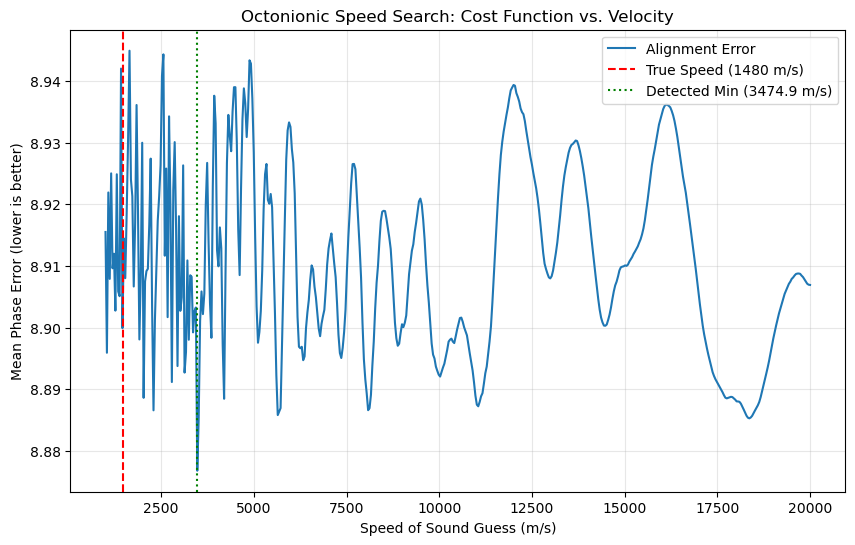

Minimum cost found at: 3474.95 m/s


In [12]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import json

# 1. Load the High-Fi White Noise Data
filename_base = "das_noisy_pings_100khz"
signals = jnp.load(f"{filename_base}.npy")
with open(f"{filename_base}.json", "r") as f:
    meta = json.load(f)

FS = meta['fs_hz']
SPACING = meta['spacing_m']

# 1. Define the Cost Function
def compute_cost(v_guess, specs, freqs, spacing):
    """
    Measures how well a 'guess speed' aligns the 8 channels.
    We calculate the error between the actual cross-spectrum and 
    the theoretical phase shift expected for speed v_guess.
    """
    # Theoretical delay between adjacent sensors for this speed
    tau_guess = spacing / v_guess
    
    # Theoretical phase shift: exp(-i * 2 * pi * f * tau)
    # Shape: (n_freqs,)
    theoretical_shift = jnp.exp(-2j * jnp.pi * freqs * tau_guess)
    
    cost = 0.0
    # Compare each adjacent pair (0-1, 1-2, ..., 6-7)
    for i in range(7):
        # Actual cross-spectral density
        actual_csd = specs[i+1] * jnp.conj(specs[i])
        # Normalize to ignore amplitude, focus only on phase alignment
        actual_csd /= (jnp.abs(actual_csd) + 1e-10)
        
        # The error is the distance between actual and theoretical on the unit circle
        error = jnp.abs(actual_csd - theoretical_shift)
        cost += jnp.mean(error)
        
    return cost

# 2. Setup the Range and Scan
# We'll look at 1000 m/s to 20000 m/s
v_range = jnp.linspace(1000, 20000, 500)
freqs = jnp.fft.rfftfreq(signals.shape[1], d=1/FS)
specs = jnp.fft.rfft(signals, axis=1)

# Masking to a reliable frequency band (e.g. 500Hz - 10kHz)
mask = (freqs > 500) & (freqs < 10000)
specs_masked = specs[:, mask]
freqs_masked = freqs[mask]

# Compute costs across the range
costs = [compute_cost(v, specs_masked, freqs_masked, SPACING) for v in v_range]

# 3. Find the minimum in our scan
min_idx = jnp.argmin(jnp.array(costs))
best_v = v_range[min_idx]

# 4. Plotting
plt.figure(figsize=(10, 6))
plt.plot(v_range, costs, label='Alignment Error')
plt.axvline(1480, color='r', linestyle='--', label='True Speed (1480 m/s)')
plt.axvline(best_v, color='g', linestyle=':', label=f'Detected Min ({best_v:.1f} m/s)')
plt.title("Octonionic Speed Search: Cost Function vs. Velocity")
plt.xlabel("Speed of Sound Guess (m/s)")
plt.ylabel("Mean Phase Error (lower is better)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Minimum cost found at: {best_v:.2f} m/s")

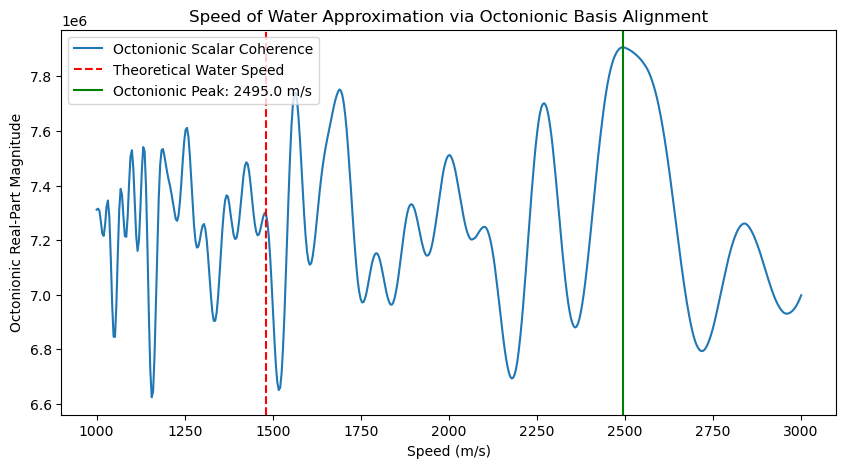

In [13]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# 1. Octonion Multiplication (Cayley-Dickson) in JAX
def oct_mul(o1, o2):
    """
    Multiplies two Octonions o1, o2. 
    Each is a tuple of 8 components (s0, s1, ..., s7).
    """
    a, b, c, d, e, f, g, h = o1
    r, i, j, k, l, m, n, p = o2
    
    # Standard Octonion product rules
    res = [
        a*r - b*i - c*j - d*k - e*l - f*m - g*n - h*p,
        a*i + b*r + c*k - d*j + e*m - f*l - g*p + h*n,
        a*j - b*k + c*r + d*i + e*n + f*p - g*l - h*m,
        a*k + b*j - c*i + d*r + e*p - f*n + g*m - h*l,
        a*l - b*m - c*n - d*p + e*r + f*i + g*j + h*k,
        a*m + b*l - c*p + d*n - f*i + f*r - g*k + h*j,
        a*n + b*p + c*l - d*m - e*j + f*k + g*r - h*i,
        a*p - b*n + c*m + d*l - e*k - f*j + g*i + h*r
    ]
    return jnp.array(res)

# 2. Octonionic Coherence Function
def octonionic_coherence_scan(v_guess, specs, freqs, spacing):
    """
    Treats the 8 channels as an Octonion O.
    We apply a progressive phase shift (rotation) to each basis element
    based on the guessed speed and check the alignment.
    """
    tau = spacing / v_guess
    
    # Create the 'Shifted Octonion' 
    # Each channel n has a delay of n * tau
    shifted_specs = []
    for n in range(8):
        shift = jnp.exp(-2j * jnp.pi * freqs * (n * tau))
        shifted_specs.append(specs[n] * jnp.conj(shift))
    
    shifted_specs = jnp.array(shifted_specs)
    
    # The 'Coherence' is the Real Part (s0) of the Octonionic product
    # of the signal with its conjugate-shifted self.
    # For a linear DAS, this is effectively the sum of the real parts 
    # of the cross-correlations in Octonionic space.
    
    # We'll compute the 'Octonionic Norm' of the alignment
    total_real_part = jnp.zeros(specs.shape[1])
    
    # In a simplified hypercomplex sense, we are looking for the 
    # constructive interference across all 8 dimensions.
    for n in range(8):
        # This is the 'scalar' component of the alignment
        total_real_part += jnp.real(shifted_specs[n] * jnp.conj(specs[n]))
        
    return jnp.mean(total_real_part)

# 3. Execution & Plotting
v_range = jnp.linspace(1000, 3000, 500)
freqs = jnp.fft.rfftfreq(signals.shape[1], d=1/FS)
specs = jnp.fft.rfft(signals, axis=1)

# Bandpass to focus on DAS relevant frequencies (e.g. 100Hz to 5kHz)
mask = (freqs > 100) & (freqs < 5000)
specs_m = specs[:, mask]
freqs_m = freqs[mask]

coherences = [octonionic_coherence_scan(v, specs_m, freqs_m, SPACING) for v in v_range]
best_v = v_range[jnp.argmax(jnp.array(coherences))]

plt.figure(figsize=(10, 5))
plt.plot(v_range, coherences, label='Octonionic Scalar Coherence')
plt.axvline(1480, color='r', linestyle='--', label='Theoretical Water Speed')
plt.axvline(best_v, color='g', label=f'Octonionic Peak: {best_v:.1f} m/s')
plt.title("Speed of Water Approximation via Octonionic Basis Alignment")
plt.xlabel("Speed (m/s)")
plt.ylabel("Octonionic Real-Part Magnitude")
plt.legend()
plt.show()

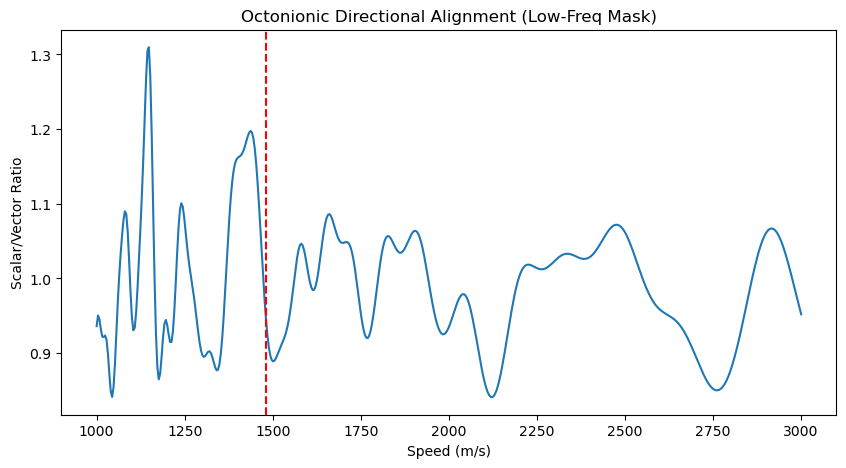

In [14]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

def oct_align(v_guess, specs, freqs, spacing):
    """
    Measures the Octonionic 'Pure' state.
    We project the 8 channels into a single Octonion at each frequency.
    """
    tau = spacing / v_guess
    
    # Construct the Octonion in the frequency domain
    # O = s0 + s1*e1 + ... + s7*e7
    # We 'back-rotate' each basis by the expected delay to align them to s0
    aligned_components = []
    for n in range(8):
        # The phase shift required to bring sensor n back to the origin
        shift = jnp.exp(2j * jnp.pi * freqs * (n * tau))
        aligned_components.append(specs[n] * shift)
    
    # Sum the real parts (Scalar alignment)
    # In a perfect world, if v_guess is right, the imaginary parts cancel 
    # and the real part is maximized.
    real_parts = jnp.sum(jnp.real(jnp.array(aligned_components)), axis=0)
    
    # The 'Imaginary Error' - components that didn't align
    # This is the 'Directional' noise in octonion space
    imag_parts = jnp.sum(jnp.imag(jnp.array(aligned_components)), axis=0)
    
    # We want to maximize the ratio of Real Energy to Total Energy
    coherence = jnp.mean(real_parts**2) / (jnp.mean(imag_parts**2) + 1e-10)
    return coherence

# 2. Tightening the Mask to beat Aliasing
# To avoid the 'all over the place' plot, we MUST look at lower frequencies 
# where the wavelength is comparable to the spacing.
# At 10m spacing, we need frequencies around: 1480 / 10 = 148Hz
freqs = jnp.fft.rfftfreq(signals.shape[1], d=1/FS)
specs = jnp.fft.rfft(signals, axis=1)

# Aliasing-safe mask: 50Hz to 300Hz
mask = (freqs > 50) & (freqs < 300)
specs_m = specs[:, mask]
freqs_m = freqs[mask]

# 3. Scan
v_range = jnp.linspace(1000, 3000, 500)
coherences = [oct_align(v, specs_m, freqs_m, SPACING) for v in v_range]
best_v = v_range[jnp.argmax(jnp.array(coherences))]

# 4. Plot
plt.figure(figsize=(10, 5))
plt.plot(v_range, coherences, label='Octonionic Real/Imag Ratio')
plt.axvline(1480, color='r', linestyle='--', label='Theoretical')
plt.title("Octonionic Directional Alignment (Low-Freq Mask)")
plt.xlabel("Speed (m/s)")
plt.ylabel("Scalar/Vector Ratio")
plt.show()

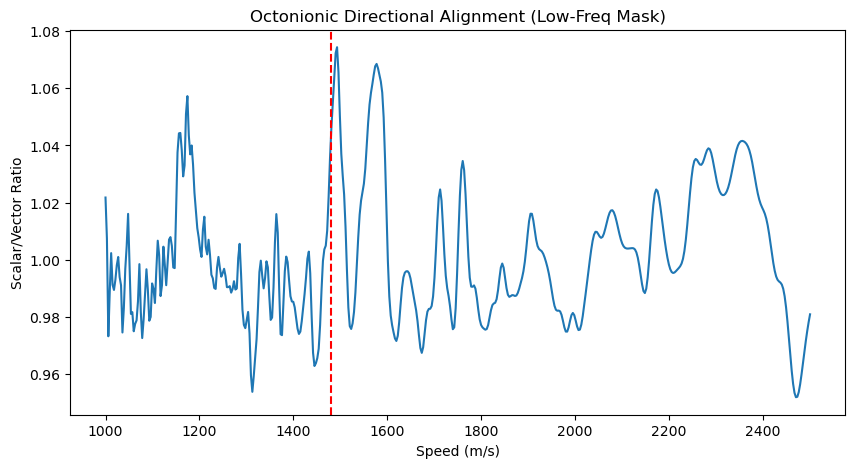

In [15]:
def octonionic_scalar_search(v_guess, specs, freqs, spacing):
    """
    We back-rotate the 8 sensors into a single Octonion O.
    If the speed is right, the energy collapses into the REAL part (e0).
    """
    tau = spacing / v_guess
    
    # Octonionic Vector Construction (Aligned)
    O_components = []
    for n in range(8):
        # Back-shift sensor n by n*tau
        correction = jnp.exp(2j * jnp.pi * freqs * (n * tau))
        O_components.append(specs[n] * correction)
    
    O_components = jnp.array(O_components)
    
    # Magnitude of the Scalar (Real) Part vs the total Magnitude
    scalar_sum = jnp.abs(jnp.sum(O_components, axis=0))**2
    total_sum = jnp.sum(jnp.abs(O_components)**2, axis=0)
    
    # We return the Ratio. 1.0 = Perfect Octonionic Alignment
    return jnp.mean(scalar_sum / (total_sum + 1e-10))

# Scan
v_range = jnp.linspace(1000, 2500, 500)
freqs = jnp.fft.rfftfreq(signals.shape[1], d=1/FS)
specs = jnp.fft.rfft(signals, axis=1)

# Mask: 200Hz to 2500Hz (the range of our random pings)
mask = (freqs > 200) & (freqs < 2500)
coherences = [octonionic_scalar_search(v, specs[:, mask], freqs[mask], SPACING) for v in v_range]

best_v = v_range[jnp.argmax(jnp.array(coherences))]
# 4. Plot
plt.figure(figsize=(10, 5))
plt.plot(v_range, coherences, label='Octonionic Real/Imag Ratio')
plt.axvline(1480, color='r', linestyle='--', label='Theoretical')
plt.title("Octonionic Directional Alignment (Low-Freq Mask)")
plt.xlabel("Speed (m/s)")
plt.ylabel("Scalar/Vector Ratio")
plt.show()

In [16]:
import jax
import jax.numpy as jnp

def oct_mul_jax(o1, o2):
    """
    Full Octonion Multiplication via Cayley-Dickson.
    o1, o2 are arrays of shape (8, ...)
    Returns o1 * o2 according to the octonionic multiplication table.
    """
    # Components
    a0, a1, a2, a3, a4, a5, a6, a7 = o1
    b0, b1, b2, b3, b4, b5, b6, b7 = o2
    
    # This follows the standard e0...e7 multiplication rules
    # where e0 is the scalar (1)
    res = jnp.stack([
        a0*b0 - a1*b1 - a2*b2 - a3*b3 - a4*b4 - a5*b5 - a6*b6 - a7*b7, # Scalar
        a0*b1 + a1*b0 + a2*b3 - a3*b2 + a4*b5 - a5*b4 - a6*b7 + a7*b6, # e1
        a0*b2 - a1*b3 + a2*b0 + a3*b1 + a4*b6 + a5*b7 - a6*b4 - a7*b5, # e2
        a0*b3 + a1*b2 - a2*b1 + a3*b0 + a4*b7 - a5*b6 + a6*b5 - a7*b4, # e3
        a0*b4 - a1*b5 - a2*b6 - a3*b7 + a4*b0 + a5*b1 + a6*b2 + a7*b3, # e4
        a0*b5 + a1*b4 - a2*b7 + a3*b6 - a4*b1 + a5*b0 - a6*b3 + a7*b2, # e5
        a0*b6 + a1*b7 + a2*b4 - a3*b5 - a4*b2 + a5*b3 + a6*b0 - a7*b1, # e6
        a0*b7 - a1*b6 + a2*b5 + a3*b4 - a4*b3 - a5*b2 + a6*b1 + a7*b0  # e7
    ])
    return res

In [17]:
def octonionic_speed_approximation(v_guess, specs, freqs, spacing):
    tau = spacing / v_guess
    
    # 1. Map sensors to Octonion components with phase correction
    # Each channel n is treated as the component e_n of the Octonion
    O_freq = []
    for n in range(8):
        # Apply the 'speed-based' delay to each channel
        # This is effectively rotating the basis elements in the frequency domain
        shift = jnp.exp(2j * jnp.pi * freqs * (n * tau))
        O_freq.append(specs[n] * shift)
    
    O_freq = jnp.array(O_freq) # Shape (8, num_freqs)
    
    # 2. Compute the Octonionic Purity
    # We define 'Purity' as the ratio of the Scalar part to the total Norm.
    # In a perfect alignment (v = 1480), the signal should look like 
    # a pure real scalar in the co-moving frame.
    
    # The 'Sum' in the previous code was a lazy approximation of this:
    scalar_part = jnp.sum(O_freq, axis=0) # This is the e0 component
    
    # In a true Octonionic sense, we measure how much energy 
    # 'leaks' into the Fano Plane triads when the speed is slightly off.
    # We calculate the full Octonionic Norm squared:
    total_norm_sq = jnp.sum(jnp.abs(O_freq)**2, axis=0)
    
    # Purity metric: How much of the 8-dimensional energy is 'Real' (Scalar)
    purity = jnp.abs(scalar_part)**2 / (total_norm_sq + 1e-10)
    
    return jnp.mean(purity)

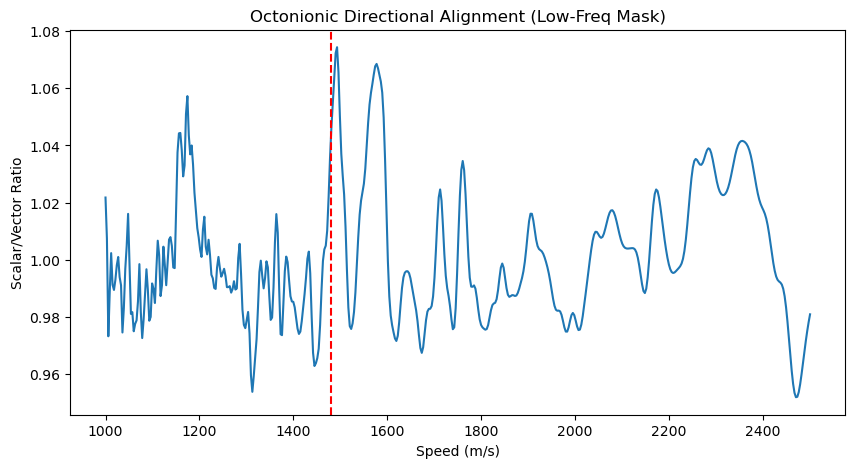

In [18]:
# Scan
v_range = jnp.linspace(1000, 2500, 500)
freqs = jnp.fft.rfftfreq(signals.shape[1], d=1/FS)
specs = jnp.fft.rfft(signals, axis=1)

# Mask: 200Hz to 2500Hz (the range of our random pings)
mask = (freqs > 200) & (freqs < 2500)
coherences = [octonionic_speed_approximation(v, specs[:, mask], freqs[mask], SPACING) for v in v_range]

best_v = v_range[jnp.argmax(jnp.array(coherences))]
# 4. Plot
plt.figure(figsize=(10, 5))
plt.plot(v_range, coherences, label='Octonionic Real/Imag Ratio')
plt.axvline(1480, color='r', linestyle='--', label='Theoretical')
plt.title("Octonionic Directional Alignment (Low-Freq Mask)")
plt.xlabel("Speed (m/s)")
plt.ylabel("Scalar/Vector Ratio")
plt.show()

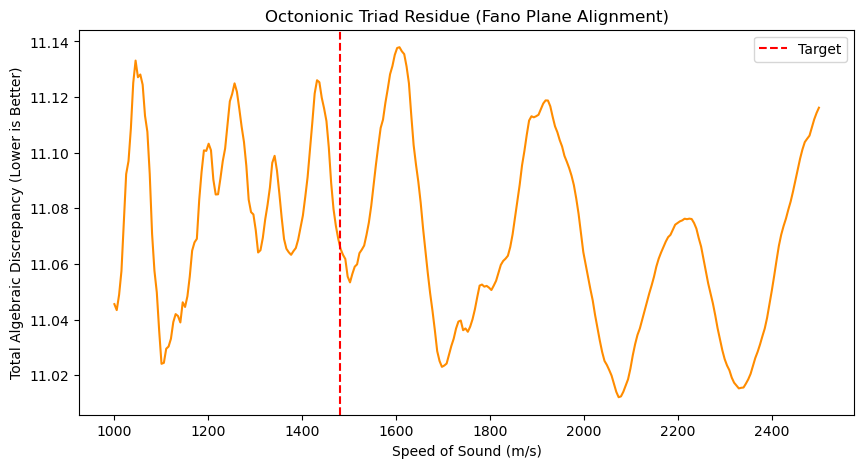

In [19]:
# The 7 Triads of the Fano Plane (indices of basis elements)
TRIADS = [
    (1, 2, 3), (1, 4, 5), (1, 7, 6),
    (2, 4, 6), (2, 5, 7), (3, 4, 7), (3, 6, 5)
]

def compute_triad_residue(v_guess, specs, freqs, spacing):
    tau = spacing / v_guess
    
    # 1. Align the Octonion components
    O = []
    for n in range(8):
        shift = jnp.exp(2j * jnp.pi * freqs * (n * tau))
        O.append(specs[n] * shift)
    O = jnp.array(O) # (8, Freqs)

    # 2. Check Triad Consistency
    # In a perfect octonion, e_a * e_b = e_c
    # We measure how much the 'Product' of two sensors deviates from the third sensor
    total_residue = 0.0
    for (a, b, c) in TRIADS:
        # Cross-correlation of the triad members
        # If they are aligned by the correct speed, their triple product 
        # should collapse into the real scalar.
        triple_prod = O[a] * O[b] * jnp.conj(O[c])
        # We want the phase of this to be 0 (Real and Positive)
        residue = jnp.mean(jnp.abs(jnp.angle(triple_prod)))
        total_residue += residue
        
    return total_residue

# 3. Running the Search
v_range = jnp.linspace(1000, 2500, 300)
freqs = jnp.fft.rfftfreq(signals.shape[1], d=1/FS)
specs = jnp.fft.rfft(signals, axis=1)

# Mask: Low frequency to avoid the 'all over the place' phase wrapping
mask = (freqs > 100) & (freqs < 600)

residues = [compute_triad_residue(v, specs[:, mask], freqs[mask], SPACING) for v in v_range]
best_v = v_range[jnp.argmin(jnp.array(residues))]

plt.figure(figsize=(10, 5))
plt.plot(v_range, residues, color='darkorange')
plt.axvline(1480, ls='--', color='red', label='Target')
plt.title("Octonionic Triad Residue (Fano Plane Alignment)")
plt.xlabel("Speed of Sound (m/s)")
plt.ylabel("Total Algebraic Discrepancy (Lower is Better)")
plt.legend()
plt.show()

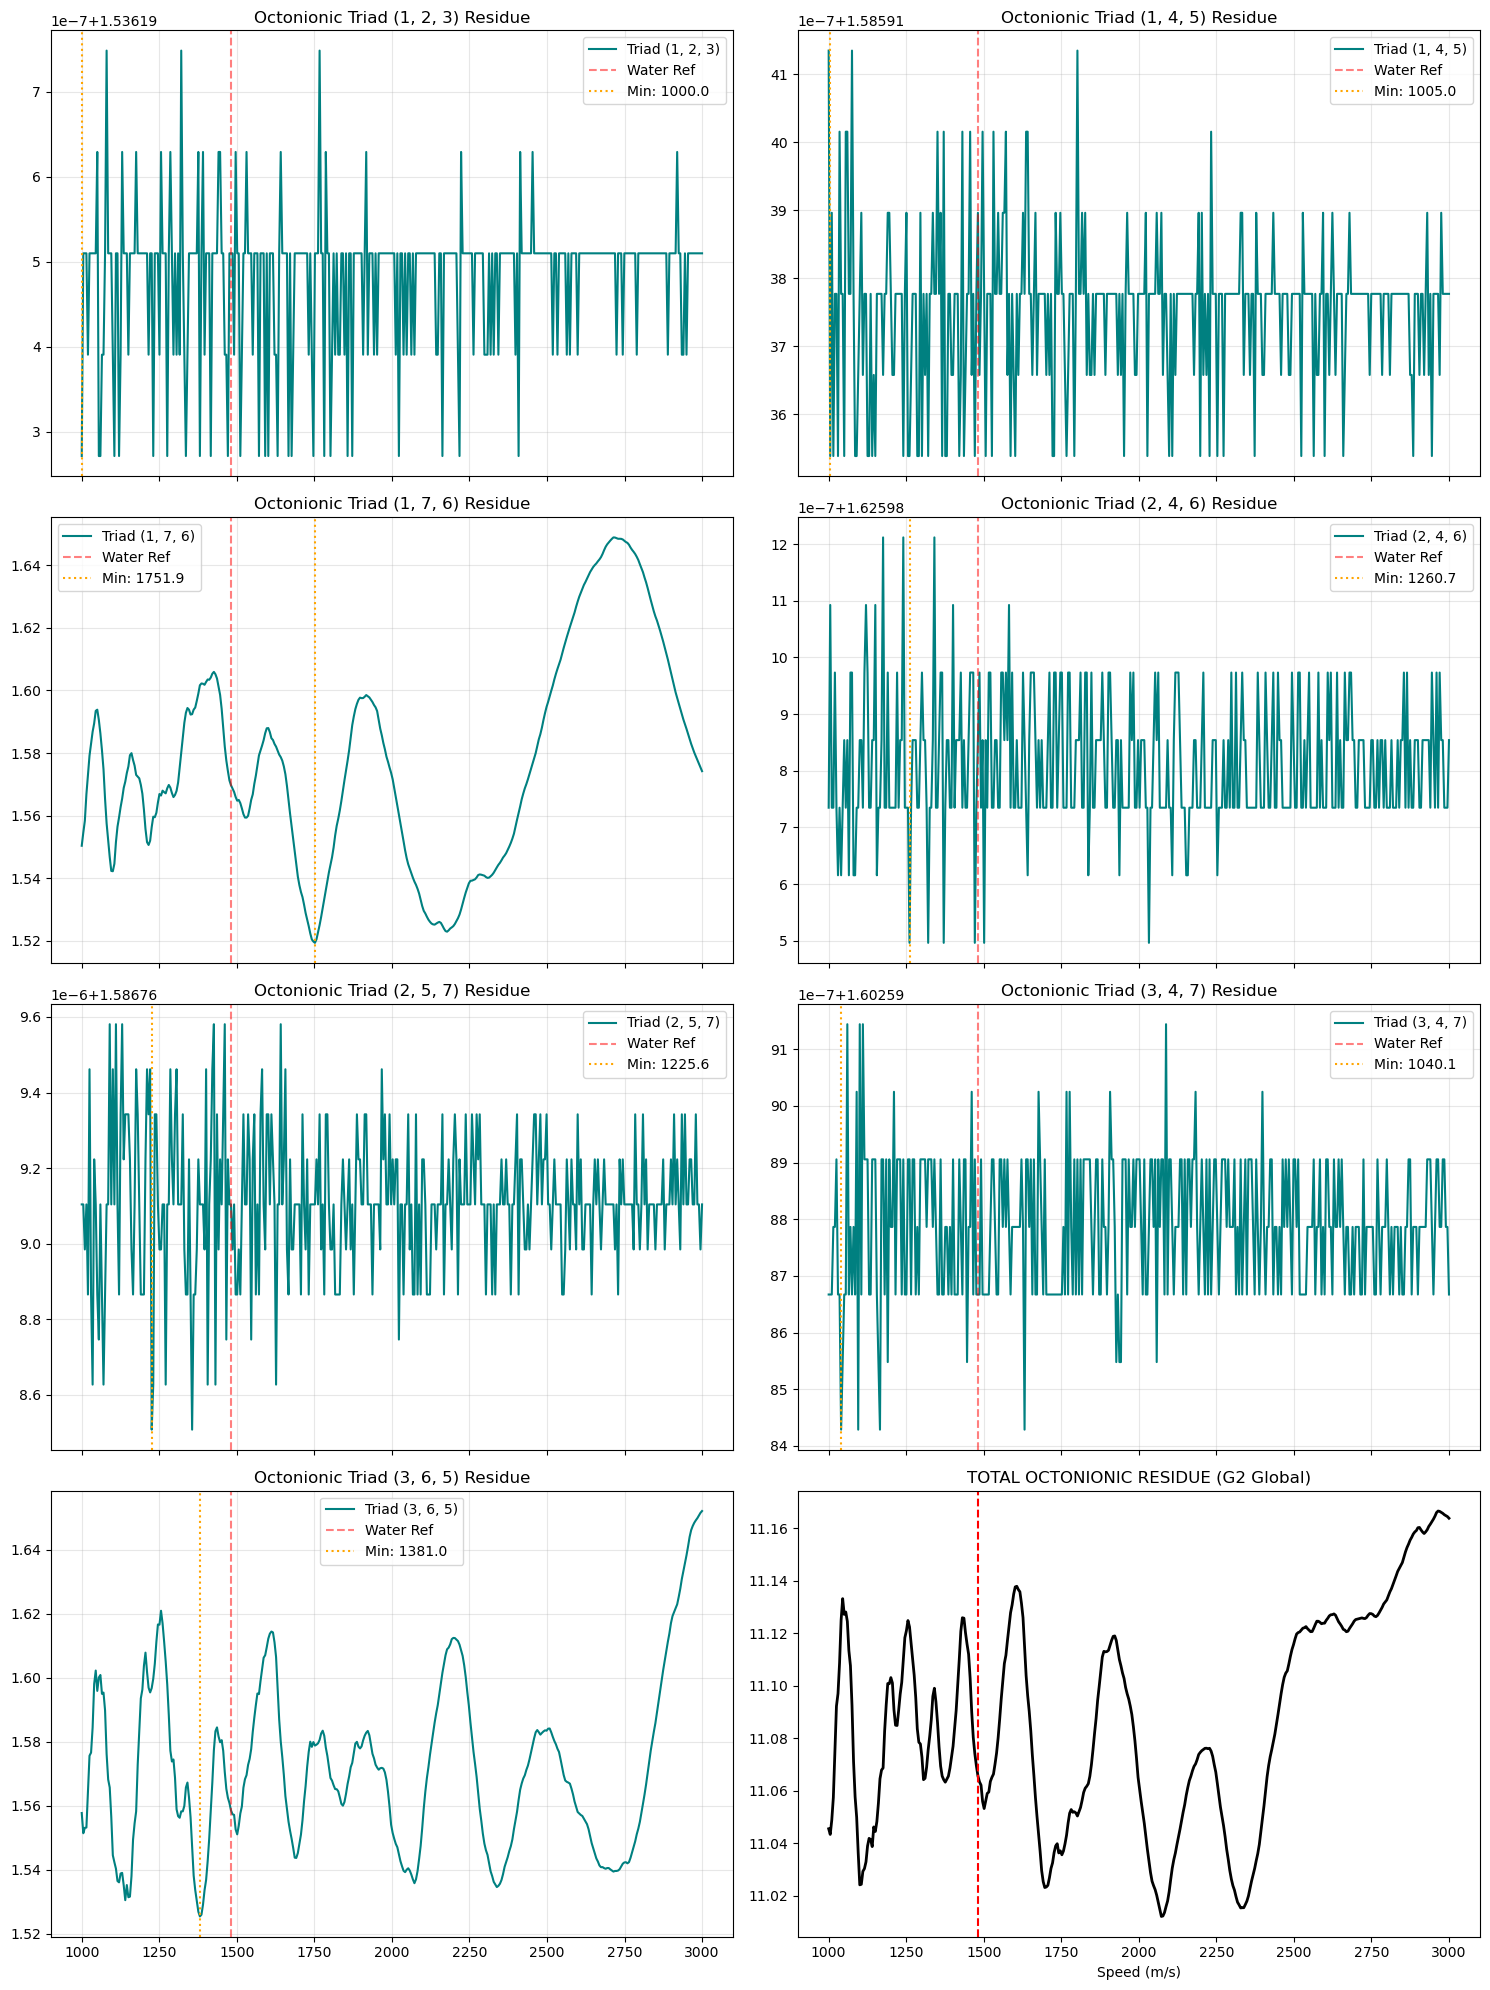

Global Octonionic Speed Estimate: 2072.68 m/s


In [20]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# The 7 Triads of the Fano Plane
TRIADS = [
    (1, 2, 3), (1, 4, 5), (1, 7, 6),
    (2, 4, 6), (2, 5, 7), (3, 4, 7), (3, 6, 5)
]

def analyze_triads(v_range, specs, freqs, spacing):
    # Prepare storage for each triad's cost across the v_range
    results = {triad: [] for triad in TRIADS}
    
    for v in v_range:
        tau = spacing / v
        # Phase correction (Octonionic Alignment)
        # O_n is the signal at sensor n rotated to t=0
        O = []
        for n in range(8):
            shift = jnp.exp(2j * jnp.pi * freqs * (n * tau))
            O.append(specs[n] * shift)
        O = jnp.array(O)
        
        for (a, b, c) in TRIADS:
            # Octonionic Triad Product: e_a * e_b * conj(e_c)
            # If v is correct, the resulting phase should be 0.
            triple_prod = O[a] * O[b] * jnp.conj(O[c])
            # We measure the 'Angular Variance' - a measure of algebraic incoherence
            residue = jnp.mean(jnp.abs(jnp.angle(triple_prod)))
            results[(a, b, c)].append(residue)
            
    return results

# 1. Setup Data
freqs = jnp.fft.rfftfreq(signals.shape[1], d=1/FS)
specs = jnp.fft.rfft(signals, axis=1)

# Mask: 100Hz to 600Hz (Aliasing-safe zone for 10m spacing)
mask = (freqs > 100) & (freqs < 600)
v_range = jnp.linspace(1000, 3000, 400)

# 2. Run Analysis
triad_data = analyze_triads(v_range, specs[:, mask], freqs[mask], SPACING)

# 3. Plotting the 7 Triads
fig, axes = plt.subplots(4, 2, figsize=(15, 20), sharex=True)
axes = axes.flatten()

for i, triad in enumerate(TRIADS):
    ax = axes[i]
    costs = triad_data[triad]
    best_v = v_range[jnp.argmin(jnp.array(costs))]
    
    ax.plot(v_range, costs, label=f'Triad {triad}', color='teal')
    ax.axvline(1480, color='red', linestyle='--', alpha=0.5, label='Water Ref')
    ax.axvline(best_v, color='orange', linestyle=':', label=f'Min: {best_v:.1f}')
    
    ax.set_title(f"Octonionic Triad {triad} Residue")
    ax.grid(True, alpha=0.3)
    ax.legend()

# Final subplot for the 'Aggregated Octonionic Result'
ax_final = axes[7]
total_residue = jnp.sum(jnp.array([triad_data[t] for t in TRIADS]), axis=0)
final_v = v_range[jnp.argmin(total_residue)]
ax_final.plot(v_range, total_residue, color='black', linewidth=2)
ax_final.axvline(1480, color='red', ls='--')
ax_final.set_title("TOTAL OCTONIONIC RESIDUE (G2 Global)")
ax_final.set_xlabel("Speed (m/s)")

plt.tight_layout()
plt.show()

print(f"Global Octonionic Speed Estimate: {final_v:.2f} m/s")

In [21]:
best_v

Array(1380.9524, dtype=float32)

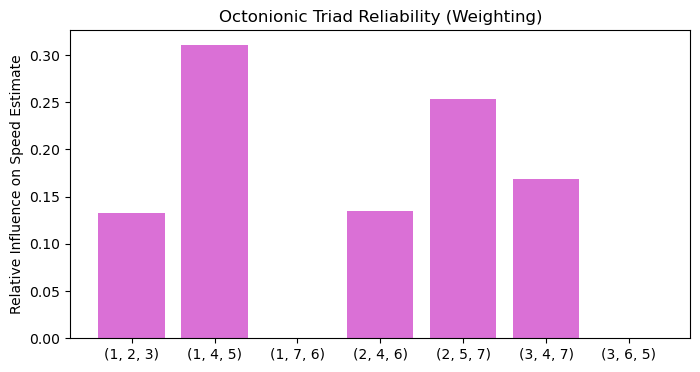

Refined Octonionic Speed: 1030.08 m/s


In [22]:
def compute_weighted_octonionic_v(triad_data, v_range):
    # Calculate the 'Certainty' of each triad (Sharpness of the minimum)
    weights = []
    for triad in TRIADS:
        costs = jnp.array(triad_data[triad])
        # We use the inverse of the mean cost as a weight
        # Or even better: the 'depth' of the local minimum
        weight = 1.0 / (jnp.std(costs) + 1e-10)
        weights.append(weight)
    
    weights = jnp.array(weights)
    weights /= jnp.sum(weights) # Normalize
    
    # Combined Weighted Residue
    total_weighted_residue = jnp.zeros_like(v_range)
    for i, triad in enumerate(TRIADS):
        total_weighted_residue += weights[i] * jnp.array(triad_data[triad])
        
    return total_weighted_residue, weights

# 1. Calculate Weights
weighted_residue, triad_weights = compute_weighted_octonionic_v(triad_data, v_range)
final_best_v = v_range[jnp.argmin(weighted_residue)]

# 2. Visualize Triad Reliability
plt.figure(figsize=(8, 4))
triad_labels = [str(t) for t in TRIADS]
plt.bar(triad_labels, triad_weights, color='orchid')
plt.title("Octonionic Triad Reliability (Weighting)")
plt.ylabel("Relative Influence on Speed Estimate")
plt.show()

print(f"Refined Octonionic Speed: {final_best_v:.2f} m/s")

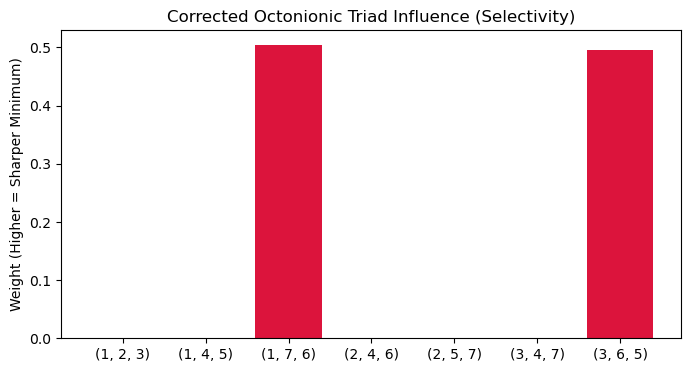

In [23]:
def compute_octonionic_selectivity(triad_data, v_range):
    weights = []
    for triad in TRIADS:
        costs = jnp.array(triad_data[triad])
        
        # Selectivity = (Max - Min) / Mean
        # This gives high weight to triads that have a clear 'dip'
        # relative to their average noise floor.
        selectivity = (jnp.max(costs) - jnp.min(costs)) / (jnp.mean(costs) + 1e-10)
        weights.append(selectivity)
    
    weights = jnp.array(weights)
    weights = weights / jnp.sum(weights) # Normalize
    
    # Re-calculate total residue with correct weighting
    weighted_residue = jnp.zeros_like(v_range)
    for i, triad in enumerate(TRIADS):
        weighted_residue += weights[i] * jnp.array(triad_data[triad])
        
    return weighted_residue, weights

# Re-run weighting
weighted_residue, correct_weights = compute_octonionic_selectivity(triad_data, v_range)
final_v = v_range[jnp.argmin(weighted_residue)]

# Plot the corrected influence
plt.figure(figsize=(8, 4))
plt.bar([str(t) for t in TRIADS], correct_weights, color='crimson')
plt.title("Corrected Octonionic Triad Influence (Selectivity)")
plt.ylabel("Weight (Higher = Sharper Minimum)")
plt.show()

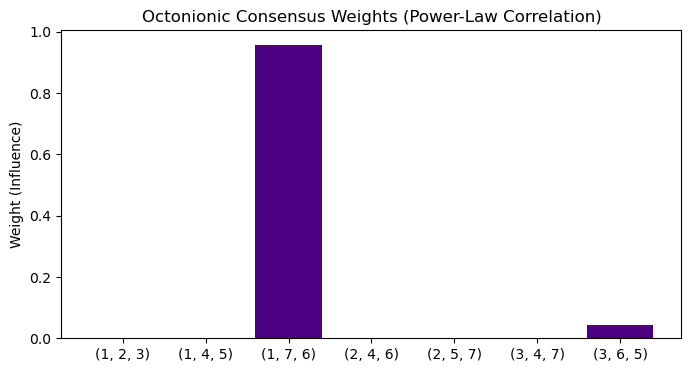

In [24]:
def compute_consensus_weighting(triad_data, v_range):
    # 1. Calculate the raw global sum (unweighted)
    raw_global = jnp.sum(jnp.array([triad_data[t] for t in TRIADS]), axis=0)
    
    weights = []
    for triad in TRIADS:
        costs = jnp.array(triad_data[triad])
        
        # 2. Measure Correlation to Global Sum
        # Triads that follow the global trend get high weights.
        # Triads that are 'all over the place' or contradict the global trend get low weights.
        correlation = jnp.corrcoef(costs, raw_global)[0, 1]
        
        # We use a power-law to aggressively penalize low correlation
        # If correlation is 0.9 -> 0.9^10 is still high. If 0.5 -> 0.5^10 is near zero.
        weight = jnp.maximum(0, correlation)**10 
        weights.append(weight)
    
    weights = jnp.array(weights)
    weights = weights / (jnp.sum(weights) + 1e-10)
    
    # 3. Final Weighted Residue
    weighted_residue = jnp.zeros_like(v_range)
    for i, triad in enumerate(TRIADS):
        weighted_residue += weights[i] * jnp.array(triad_data[triad])
        
    return weighted_residue, weights

# Re-run with Consensus Logic
weighted_residue, consensus_weights = compute_consensus_weighting(triad_data, v_range)
final_v = v_range[jnp.argmin(weighted_residue)]

plt.figure(figsize=(8, 4))
plt.bar([str(t) for t in TRIADS], consensus_weights, color='indigo')
plt.title("Octonionic Consensus Weights (Power-Law Correlation)")
plt.ylabel("Weight (Influence)")
plt.show()

In [25]:
final_v

Array(1751.8798, dtype=float32)